# Selective Mask

This version update:
- uses `openslide` to view the `.tiff` files instead of the previous version that involved coverting the files from `.tiff` to `.png`
- each image is categorized by an `isup_grade` and we can selectively choose what grade to view by specifying `min_px` and `max_px` values
- load the selective mask into a `DataLoader`

### Original Mask

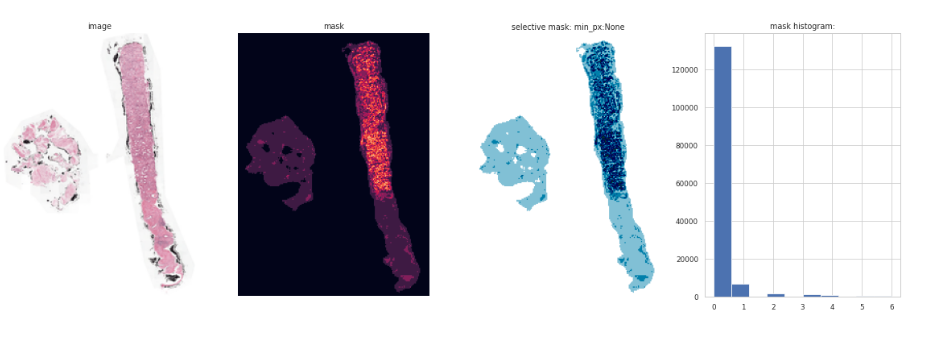

### Selective Mask
`min_px` value of 3

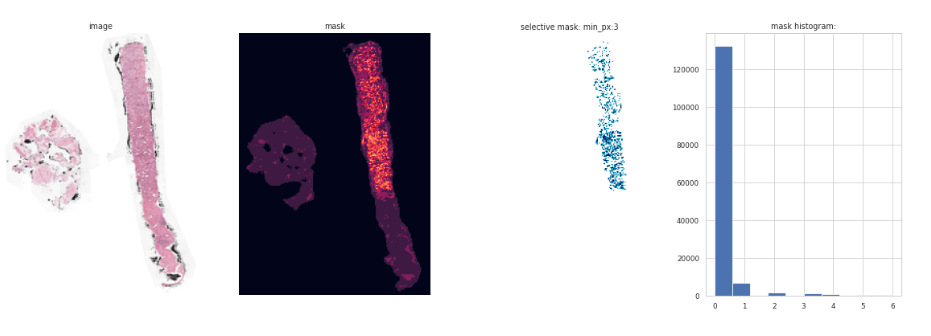

# Load the dependencies

In [ ]:
!pip install fastai2 -q

In [ ]:
#Load the dependancies
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

import seaborn as sns
import numpy as np
import pandas as pd
import os
import cv2
import openslide

sns.set(style="whitegrid")
sns.set_context("paper")

matplotlib.rcParams['image.cmap'] = 'ocean_r'

In [ ]:
source = Path("../input/prostate-cancer-grade-assessment")
files = os.listdir(source)
files

Specify the folders

In [ ]:
train = source/'train_images'
mask = source/'train_label_masks'
train_labels = pd.read_csv(source/'train.csv')
train_labels.head()

# Viewing an image

You can view the images and masks by specifying their filename.  The only difference in the naming between the images and masks is that the mask filenames have `_mask` before the file type.

The masks are saved in RGB format and the mask is stored in the red channel and the rest of the channels are set to 0. To view the mask we have to explicity display only that channel.

We can create a function to view the images and masks using `openslide` that takes into consideration where the image is stored, if the non-mask image display the image as is or if it is the mask image display the red channel only.

In [ ]:
def view_image(folder, fn):
    if folder == train:
        filename = f'{folder}/{fn}.tiff'
    if folder == mask:
        filename = f'{folder}/{fn}_mask.tiff'
    file = openslide.OpenSlide(str(filename))
    t = tensor(file.get_thumbnail(size=(255, 255)))
    if folder == train:
        show_image(t)
    if folder == mask:
        show_image(t[:,:,0])

View an image

In [ ]:
view_image(train, '0005f7aaab2800f6170c399693a96917')

View the corresponding mask

In [ ]:
view_image(mask, '0005f7aaab2800f6170c399693a96917')

The dataset is categorized by both `isup_grade` and `gleason_score`.  What is noticed is that the masks have different intensities.  For example we can specify a function that will display the image, the mask and plot a histogram of the intensites. 

In [ ]:
def view_images(file, mask, fn):
    ima = f'{file}/{fn}.tiff'
    msk = f'{mask}/{fn}_mask.tiff'
    ima_file = openslide.OpenSlide(str(ima)); ima_t = tensor(ima_file.get_thumbnail(size=(255, 255)))
    ima_msk = openslide.OpenSlide(str(msk)); msk_t = tensor(ima_msk.get_thumbnail(size=(255, 255)))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20, 6))
    s1 = show_image(ima_t, ax=ax1, title='image')
    s2 = show_image(msk_t[:,:,0], ax=ax2, title='mask')
    s3 = plt.hist(msk_t.flatten()); plt.title('mask histogram')
    plt.show()

In [ ]:
view_images(train, mask, '06636cdd43041e78141f2f5069fa62d5')

Plotting a histogram of the mask intensities shows that the bulk of the intensity is between `0` and `1` and this corresponds to the the bulk of the pixels which is the outline of the mask (light blue)

Here are some more examples:

In [ ]:
view_images(train, mask, '0d3159cd1b2495cc82637ececf63ed41')

In [ ]:
view_images(train, mask, '08134913a9aa1d541f719e9f356f9378')

Can see that the bulk of the pixels within the mask are the light blue areas of the mask which correspond to the the out outline of the mask itself.  

# Selective Mask

To be able to view the mask images at different intensities I adapted a function from `fastai`'s medical imaging library (which is typically geared towards working with DICOM images). To learn more about `fastai`'s medical imaging module please read my blog [here](https://asvcode.github.io/MedicalImaging/) or view this [notebook](https://www.kaggle.com/avirdee/fastai2-dicom-starter)

Load the medical imaging library

In [ ]:
from fastai2.medical.imaging import *

This library has a `show` function that has the capability of specifying max and min pixel values so you can specify the range of pixels you want to view within an image (useful when DICOM images can vary in pixel values between the range of -32768 to 32768).
 
You can easily adapt any function in `fastai2` using `@patch` and it just works!  In this case I am adapting the `show` function so you can specify `min` and `max` pixel values for this dataset.

In [ ]:
@patch
@delegates(show_image)
def show(self:PILImage, scale=True, cmap=plt.cm.ocean_r, min_px=None, max_px=None, **kwargs):
    px = tensor(self)
    if min_px is not None: px[px<min_px] = float(min_px)
    if max_px is not None: px[px>max_px] = float(max_px)
    show_image(px, cmap=cmap, **kwargs)

We will also have to define another function that will allow us to view the selective masks

In [ ]:
def selective_mask(file, mask, fn, min_px=None, max_px=None):
    ima = f'{file}/{fn}.tiff'
    msk = f'{mask}/{fn}_mask.tiff'
    ima_file = openslide.OpenSlide(str(ima)); ima_t = tensor(ima_file.get_thumbnail(size=(255, 255)))
    ima_msk = openslide.OpenSlide(str(msk)); msk_t = tensor(ima_msk.get_thumbnail(size=(255, 255)))
    msk_pil = PILImage.create(msk_t[:,:,0])
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20, 6))
    s1 = show_image(ima_t, ax=ax1, title='image')
    s2 = show_image(msk_t[:,:,0], ax=ax2, title='mask')
    s3 = msk_pil.show(min_px=min_px, max_px=max_px, ax=ax3, title=f'selective mask: min_px:{min_px}')
    s4 = plt.hist(msk_t.flatten()); plt.title('mask histogram')
    plt.show()

The plot shows the original image, the mask, the selective mask(in this case all intensities are shown hence the reason it looks the same as the mask image) and the histogram of intensities (again the bulk of pixels are within `0` and `1`

In [ ]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=None, max_px=None)

How about intensities above 1 (so getting rid of the bulk of pixels)

In [ ]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=1, max_px=None)

Intensities above 2

In [ ]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=2, max_px=None)

Intensities above 3

In [ ]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=3, max_px=None)

The histogram does show some pixels above 4 but not many

In [ ]:
selective_mask(train, mask, '08134913a9aa1d541f719e9f356f9378', min_px=4, max_px=None)

Looking at the selective masks side by side

In [ ]:
msk = f'{mask}/08134913a9aa1d541f719e9f356f9378_mask.tiff'
ima_msk = openslide.OpenSlide(str(msk)); msk_t = tensor(ima_msk.get_thumbnail(size=(255, 255)))
msk_pil = PILImage.create(msk_t[:,:,0])

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 6))
s1 = msk_pil.show(min_px=None, max_px=None, ax=ax1, title='original mask')
s2 = msk_pil.show(min_px=1, max_px=2, ax=ax2, title='1 and 2')
s3 = msk_pil.show(min_px=2, max_px=3, ax=ax3, title='2 and 3')
s4 = msk_pil.show(min_px=3, max_px=4, ax=ax4, title='3 and 4')
s4 = msk_pil.show(min_px=4, max_px=5, ax=ax5, title='4 and 5')
plt.show()

lets check to see what the `isup_grade` of the example above is:

In [ ]:
train_labels[train_labels.values == '08134913a9aa1d541f719e9f356f9378']

It has an `isup_grade` of 4

### isup_grade = 0

Lets check an example with `isup_grade` of 0

In [ ]:
isup_0 = train_labels[train_labels.isup_grade == 0]
isup_0[:1]

In [ ]:
selective_mask(train, mask, '0005f7aaab2800f6170c399693a96917', min_px=None, max_px=None)

### isup_grade = 5

What about images with `isup_grade` of 5

In [ ]:
isup_5 = train_labels[train_labels.isup_grade == 5]
isup_5[:1]

In [ ]:
selective_mask(train, mask, '00928370e2dfeb8a507667ef1d4efcbb', min_px=None, max_px=None)

It looks like:
- each mask has intensities based on its `isup_grade`

# DataBlock

Lets see what the `dataBlock` would look like.  `fastai` provides a very convenient way of getting the dataset ready for training for example you can specify `blocks` and `getters` where `blocks` can be images, labels etc and `getters` are where are the images or labels located.

For this we would have to create 2 custom functions, one so that that the `dataloader` can correctly view the images (as they are in `.tiff` format and `fastai` does not have an out of the box method of parsing these files and the second so that we only view the masks in the red channel

As we'll be using the `csv` file to load the images

In [ ]:
def custom_img(fn):
    fn = f'{train}/{fn.image_id}.tiff'
    file = openslide.OpenSlide(str(fn))
    t = tensor(file.get_thumbnail(size=(255, 255)))
    img_pil = PILImage.create(t)
    return img_pil

For the masks

We have to make a custom function `show_selective` so that we can pass the different intensities to the `dataloader`

In [ ]:
def show_selective(p, scale=True, cmap=plt.cm.ocean_r, min_px=None, max_px=None):
    px = tensor(p)
    if min_px is not None: px[px<min_px] = float(min_px)
    if max_px is not None: px[px>max_px] = float(max_px)
    return px

In [ ]:
def custom_selective_msk(fn):
    fn = f'{mask}/{fn.image_id}_mask.tiff'
    file = openslide.OpenSlide(str(fn))
    t = tensor(file.get_thumbnail(size=(255, 255)))[:,:,0]
    ts = show_selective(t, min_px=None, max_px=None)
    return ts

Specify the `blocks`

Lets look at images and masks side by side just to see what the images and masks look like

### Using original mask

In [ ]:
blocks = (ImageBlock,
          ImageBlock)

getters = [
           custom_img,
           custom_selective_msk
          ]

In [ ]:
prostate = DataBlock(blocks=blocks,
                 getters=getters,
                 item_tfms=Resize(128))

j = prostate.dataloaders(train_labels, bs=16)
j.show_batch(max_n=12, nrows=2, ncols=6)

The batch above shows the images and masks side by side, in this case the full mask is being shown.  However what if we specify the mask intensites, as an example I want to get rid of the bulk of images which is predominantly the outline of the mask or any intensitiy below 1

### Using Selective mask

Specify the min_px value as 1 in the `custom_selective_msk` function:

In [ ]:
def custom_selective_msk(fn):
    fn = f'{mask}/{fn.image_id}_mask.tiff'
    file = openslide.OpenSlide(str(fn))
    t = tensor(file.get_thumbnail(size=(255, 255)))[:,:,0]
    ts = show_selective(t, min_px=1, max_px=None)
    return ts

In [ ]:
blocks = (ImageBlock,
          ImageBlock)

getters = [
           custom_img,
           custom_selective_msk
          ]

In [ ]:
prostate = DataBlock(blocks=blocks,
                 getters=getters,
                 item_tfms=Resize(128))

j = prostate.dataloaders(train_labels, bs=16)
j.show_batch(max_n=12, nrows=2, ncols=6)

We can see that the mask images are selective.  The mask images that are fully purple correspond to images that have an `isup_grade` of 0

Now lets look at the images and masks over-layed on each other.  For this we simply change the `ImageBlock` we used above for the mask images into a `MaskBlock` and lets add a `CategoryBlock` so that we can identify the `isup_grade`

In [ ]:
def custom_selective_msk(fn):
    fn = f'{mask}/{fn.image_id}_mask.tiff'
    file = openslide.OpenSlide(str(fn))
    t = tensor(file.get_thumbnail(size=(255, 255)))[:,:,0]
    ts = show_selective(t, min_px=None, max_px=None)
    return ts

In [ ]:
blocks = (ImageBlock,
          MaskBlock,
          CategoryBlock)

getters = [
           custom_img,
           custom_selective_msk,
           ColReader('isup_grade')
          ]

In [ ]:
prostate = DataBlock(blocks=blocks,
                 getters=getters,
                 item_tfms=Resize(224))

j = prostate.dataloaders(train_labels, bs=16)
j.show_batch(max_n=4)

# Next Steps

There is still alot of experimentation to be done.

- for example the data is extremely unbalanced but images with say `isup_grade` of 5 also have masks for grades 2,3 and 4 
- extract the portions within the masks to create a seperate dataset